# Vision Transformer (ViT) model

In [ ]:
# import tensorflow as tf
# import os
# import numpy as np
# from tensorflow.keras import layers
# from tensorflow.keras.models import Model
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image
# import matplotlib.pyplot as plt

In [ ]:
# # Define Vision Transformer Model
# def create_vit_model(input_shape, num_classes, patch_size=16, projection_dim=64, transformer_layers=4, num_heads=4):
#     inputs = layers.Input(shape=input_shape)
    
#     # Patching
#     patches = layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
#     patches_flat = layers.Reshape((-1, projection_dim))(patches)

#     # Positional Encoding
#     positions = tf.range(start=0, limit=patches_flat.shape[1], delta=1)
#     position_embedding = layers.Embedding(input_dim=patches_flat.shape[1], output_dim=projection_dim)(positions)
#     patches_encoded = patches_flat + position_embedding

#     # Transformer Layers
#     for _ in range(transformer_layers):
#         # Multi-Head Attention
#         attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(patches_encoded, patches_encoded)
#         attention_output = layers.Add()([patches_encoded, attention_output])  # Residual
#         attention_output = layers.LayerNormalization()(attention_output)

#         # Feed-Forward Network
#         ff_output = layers.Dense(2 * projection_dim, activation="relu")(attention_output)
#         ff_output = layers.Dense(projection_dim)(ff_output)
#         patches_encoded = layers.Add()([attention_output, ff_output])  # Residual
#         patches_encoded = layers.LayerNormalization()(patches_encoded)

#     # Classification Head
#     representation = layers.GlobalAveragePooling1D()(patches_encoded)
#     outputs = layers.Dense(num_classes, activation="softmax")(representation)
#     return Model(inputs, outputs)

# # Function to Train the Model
# def train_vit(train_dir, test_dir, input_shape, num_classes, batch_size=32, epochs=10, model_path='vit_model.h5'):
#     # Data Generators
#     train_datagen = ImageDataGenerator(rescale=1./255)
#     test_datagen = ImageDataGenerator(rescale=1./255)

#     train_generator = train_datagen.flow_from_directory(
#         train_dir,
#         target_size=input_shape[:2],
#         batch_size=batch_size,
#         class_mode='categorical'
#     )
#     test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=input_shape[:2],
#         batch_size=batch_size,
#         class_mode='categorical'
#     )

#     # Create Model
#     model = create_vit_model(input_shape, num_classes)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train Model
#     model.fit(train_generator, validation_data=test_generator, epochs=epochs)
#     model.save(model_path)

# # Function to Predict Test Images
# def predict_test_images(test_dir, model_path, input_shape):
#     test_datagen = ImageDataGenerator(rescale=1./255)
#     test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=input_shape[:2],
#         batch_size=1,
#         class_mode='categorical',
#         shuffle=False
#     )
#     model = load_model(model_path)
#     predictions = model.predict(test_generator)
#     predicted_classes = np.argmax(predictions, axis=1)
#     true_classes = test_generator.classes

#     # Print Accuracy
#     accuracy = np.mean(predicted_classes == true_classes)
#     print(f"Test Accuracy: {accuracy * 100:.2f}%")

# # Function to Predict a User-Provided Image
# def predict_single_image(image_path, model_path, input_shape, class_indices):
#     model = load_model(model_path)
#     img = image.load_img(image_path, target_size=input_shape[:2])
#     img_array = image.img_to_array(img) / 255.0
#     img_array = np.expand_dims(img_array, axis=0)

#     predictions = model.predict(img_array)
# #     print(f"predictions: {predictions}")
#     predicted_class = np.argmax(predictions, axis=1)[0]
# #     print(f"predicted_class: {predicted_class}")

#     # Map predicted class index to class name
#     # class_labels = {v: k for k, v in class_indices.items()}
#     # print(f"class_labels: {class_labels}")
#     print(f"Predicted Class: {class_indices[predicted_class]}")


In [ ]:
# source_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'images')
# destination_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data')

In [ ]:
# # Split dataset
# import splitfolders

# source_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'images')
# destination_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data')

# splitfolders.ratio(source_dataset_path,
#                    destination_dataset_path,
#                    seed = 41,
#                    ratio=(0.7, 0.2, 0.1)) # train/val/test

In [ ]:
# if __name__ == "__main__":
#     # Define Parameters
#     input_shape = (224, 224, 3)
#     train_dir = os.path.join(destination_dataset_path, 'train')
#     test_dir = os.path.join(destination_dataset_path, 'val')
#     num_classes = len(os.listdir(train_dir))
#     model_path = os.path.join('..', 'Models', 'vit_model.h5')

#     # Train Model
#     train_vit(train_dir, test_dir, input_shape, num_classes, epochs=100, model_path=model_path)

#     # Predict Test Images
#     predict_test_images(test_dir, model_path, input_shape)

#     # Predict Single Image
#     class_indices = {i: class_name for i, class_name in enumerate(os.listdir(train_dir))}
#     image_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data', 'test', 'Acadian_Flycatcher', "Acadian_Flycatcher_0014_795607.jpg") 
#     predict_single_image(image_path, model_path, input_shape, class_indices)

Note: Above part is working.

## Part 2

In [ ]:
# import tensorflow as tf
# import os
# import numpy as np
# import seaborn as sns
# import matplotlib.pyplot as plt
# from sklearn.metrics import classification_report, cohen_kappa_score, confusion_matrix, accuracy_score, precision_recall_fscore_support
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# from tensorflow.keras.models import load_model
# from tensorflow.keras.preprocessing import image

In [ ]:
# # Define Vision Transformer Model
# def create_vit_model(input_shape, num_classes, patch_size=16, projection_dim=64, transformer_layers=4, num_heads=4):
#     inputs = tf.keras.layers.Input(shape=input_shape)

#     # Patching
#     patches = tf.keras.layers.Conv2D(filters=projection_dim, kernel_size=patch_size, strides=patch_size, padding='valid')(inputs)
#     patches_flat = tf.keras.layers.Reshape((-1, projection_dim))(patches)

#     # Positional Encoding
#     positions = tf.range(start=0, limit=patches_flat.shape[1], delta=1)
#     position_embedding = tf.keras.layers.Embedding(input_dim=patches_flat.shape[1], output_dim=projection_dim)(positions)
#     patches_encoded = patches_flat + position_embedding

#     # Transformer Layers
#     for _ in range(transformer_layers):
#         # Multi-Head Attention
#         attention_output = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim)(patches_encoded, patches_encoded)
#         attention_output = tf.keras.layers.Add()([patches_encoded, attention_output])  # Residual
#         attention_output = tf.keras.layers.LayerNormalization()(attention_output)

#         # Feed-Forward Network
#         ff_output = tf.keras.layers.Dense(2 * projection_dim, activation="relu")(attention_output)
#         ff_output = tf.keras.layers.Dense(projection_dim)(ff_output)
#         patches_encoded = tf.keras.layers.Add()([attention_output, ff_output])  # Residual
#         patches_encoded = tf.keras.layers.LayerNormalization()(patches_encoded)

#     # Classification Head
#     representation = tf.keras.layers.GlobalAveragePooling1D()(patches_encoded)
#     outputs = tf.keras.layers.Dense(num_classes, activation="softmax")(representation)
#     return tf.keras.Model(inputs, outputs)

# # Function to Train the Model
# def train_vit(train_dir, test_dir, input_shape, num_classes, batch_size=32, epochs=10, model_path='vit_model.h5'):
#     # Data Generators
#     train_datagen = ImageDataGenerator(rescale=1./255, 
#                                        horizontal_flip=True, 
#                                        height_shift_range=0.1, 
#                                        width_shift_range=0.1, 
#                                        brightness_range=(0.5,1.5), 
#                                        zoom_range = [1, 1.5])
#     test_datagen = ImageDataGenerator(rescale=1./255)

#     train_generator = train_datagen.flow_from_directory(
#         train_dir,
#         target_size=input_shape[:2],
#         batch_size=batch_size,
#         class_mode='categorical'
#     )
#     test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=input_shape[:2],
#         batch_size=batch_size,
#         class_mode='categorical'
#     )

#     # Create Model
#     # model = create_vit_model(input_shape, num_classes)
#     model = create_vit_model(input_shape, num_classes, patch_size=16, projection_dim=196, transformer_layers=16, num_heads=4)
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

#     # Train Model
#     history = model.fit(train_generator, validation_data=test_generator, epochs=epochs)

#     # Save Model
#     model.save(model_path)

#     # Save Plots
#     plot_training_metrics(history, 'training_metrics.png')

# # Function to Plot Training Metrics
# def plot_training_metrics(history, save_path):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']

#     epochs = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 6))

#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, acc, label='Training Accuracy')
#     plt.plot(epochs, val_acc, label='Validation Accuracy')
#     plt.title('Accuracy')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, loss, label='Training Loss')
#     plt.plot(epochs, val_loss, label='Validation Loss')
#     plt.title('Loss')
#     plt.legend()

#     plt.savefig(save_path)
#     plt.close()

# # Function to Evaluate the Model and Generate Metrics
# def evaluate_model(test_dir, model_path, input_shape, class_indices):
#     test_datagen = ImageDataGenerator(rescale=1./255)
#     test_generator = test_datagen.flow_from_directory(
#         test_dir,
#         target_size=input_shape[:2],
#         batch_size=1,
#         class_mode='categorical',
#         shuffle=False
#     )
#     model = load_model(model_path)
#     predictions = model.predict(test_generator)
#     predicted_classes = np.argmax(predictions, axis=1)
#     true_classes = test_generator.classes
#     class_labels = {v: k for k, v in class_indices.items()}

#     # Metrics
#     accuracy = accuracy_score(true_classes, predicted_classes)
#     precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average='weighted')
#     kappa = cohen_kappa_score(true_classes, predicted_classes)
#     cm = confusion_matrix(true_classes, predicted_classes)

#     # Print Metrics
#     print(f"Accuracy: {accuracy:.2f}")
#     print(f"Precision: {precision:.2f}")
#     print(f"Recall: {recall:.2f}")
#     print(f"F1 Score: {f1:.2f}")
#     print(f"Cohen's Kappa: {kappa:.2f}")

#     # Plot Confusion Matrix
#     plt.figure(figsize=(10, 7))
#     sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels.values(), yticklabels=class_labels.values())
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.savefig("confusion_matrix.png")
#     plt.close()

#     return accuracy, precision, recall, f1, kappa


In [ ]:
# if __name__ == "__main__":
#     # Define Parameters
#     input_shape = (224, 224, 3)
#     train_dir = os.path.join(destination_dataset_path, 'train')
#     test_dir = os.path.join(destination_dataset_path, 'val')
#     num_classes = len(os.listdir(train_dir))
#     model_path = os.path.join('..', 'Models', 'vit_model_2.h5')

#     # Train Model
#     train_vit(train_dir, test_dir, input_shape, num_classes, epochs=100, model_path=model_path)

#     # Evaluate Model
#     class_indices = {i: class_name for i, class_name in enumerate(os.listdir(train_dir))}
#     evaluate_model(test_dir, model_path, input_shape, class_indices)
    
#     # Predict Single Image
#     class_indices = {i: class_name for i, class_name in enumerate(os.listdir(train_dir))}
#     image_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data', 'test', 'Acadian_Flycatcher', "Acadian_Flycatcher_0014_795607.jpg") 
#     predict_single_image(image_path, model_path, input_shape, class_indices)

## 20250115



In [8]:
# import os
# import numpy as np

# import tensorflow as tf
# import keras
# from keras import layers, Model
# from keras.preprocessing.image import ImageDataGenerator
# from keras.models import load_model

# from sklearn.metrics import accuracy_score, precision_recall_fscore_support, cohen_kappa_score, confusion_matrix

# import seaborn as sns
# import matplotlib.pyplot as plt

In [35]:
# # Define parameters
# input_shape = (224, 224, 3)
# patch_size = 16
# num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
# projection_dim = 64
# transformer_layers = 4
# num_heads = 4
# transformer_units = [projection_dim * 2, projection_dim]
# mlp_head_units = [2048, 1024]
# num_classes = 10  # Update based on your dataset

# source_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'images')
# destination_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data')
# model_dir = os.path.join('..', 'Models')

# # Define the MLP block
# def mlp(x, hidden_units, dropout_rate):
#     for units in hidden_units:
#         x = layers.Dense(units, activation=tf.nn.gelu)(x)
#         x = layers.Dropout(dropout_rate)(x)
#     return x

# # Define the patching layer
# class Patches(layers.Layer):
#     def __init__(self, patch_size):
#         super().__init__()
#         self.patch_size = patch_size

#     def call(self, images):
#         batch_size = tf.shape(images)[0]
#         patches = tf.image.extract_patches(
#             images=images,
#             sizes=[1, self.patch_size, self.patch_size, 1],
#             strides=[1, self.patch_size, self.patch_size, 1],
#             rates=[1, 1, 1, 1],
#             padding="VALID",
#         )
#         patch_dims = patches.shape[-1]
#         patches = tf.reshape(patches, [batch_size, -1, patch_dims])
#         return patches

# # Define the patch encoding layer
# class PatchEncoder(layers.Layer):
#     def __init__(self, num_patches, projection_dim):
#         super().__init__()
#         self.num_patches = num_patches
#         self.projection = layers.Dense(units=projection_dim)
#         self.position_embedding = layers.Embedding(
#             input_dim=num_patches, output_dim=projection_dim
#         )

#     def call(self, patches):
#         positions = tf.range(start=0, limit=self.num_patches, delta=1)
#         encoded = self.projection(patches) + self.position_embedding(positions)
#         return encoded

# # Define the data augmentation block
# data_augmentation = keras.Sequential(
#     [
#         layers.Normalization(),
#         layers.Resizing(224, 224),
#         layers.RandomFlip("horizontal"),
#         layers.RandomRotation(0.1),
#     ],
#     name="data_augmentation",
# )

# # Create the Vision Transformer model
# def create_vit_classifier(input_shape, num_classes):
#     inputs = keras.Input(shape=input_shape)
#     augmented = data_augmentation(inputs)
#     patches = Patches(patch_size)(augmented)
#     encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

#     for _ in range(transformer_layers):
#         x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#         attention_output = layers.MultiHeadAttention(
#             num_heads=num_heads, key_dim=projection_dim, dropout=0.1
#         )(x1, x1)
#         x2 = layers.Add()([attention_output, encoded_patches])
#         x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
#         x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
#         encoded_patches = layers.Add()([x3, x2])

#     representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
#     representation = layers.GlobalAveragePooling1D()(representation)
#     representation = layers.Dropout(0.5)(representation)
#     features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
#     logits = layers.Dense(num_classes, activation="softmax")(features)
#     model = keras.Model(inputs=inputs, outputs=logits)
#     model.summary()
#     return model

# # Function to plot training metrics
# def plot_training_metrics(history, save_path):
#     acc = history.history['accuracy']
#     val_acc = history.history['val_accuracy']
#     loss = history.history['loss']
#     val_loss = history.history['val_loss']

#     epochs = range(1, len(acc) + 1)

#     plt.figure(figsize=(12, 6))
#     plt.subplot(1, 2, 1)
#     plt.plot(epochs, acc, label='Training Accuracy')
#     plt.plot(epochs, val_acc, label='Validation Accuracy')
#     plt.title('Accuracy')
#     plt.legend()

#     plt.subplot(1, 2, 2)
#     plt.plot(epochs, loss, label='Training Loss')
#     plt.plot(epochs, val_loss, label='Validation Loss')
#     plt.title('Loss')
#     plt.legend()

#     plt.savefig(save_path)
#     plt.close()

# # Function to train and save checkpoints

# def train_vit(train_dir, test_dir, input_shape, num_classes, batch_size=32, epochs=10, model_path="vit_model.h5"):
#     train_gen = ImageDataGenerator(rescale=1.0/255 
# #                                    horizontal_flip=True, 
# #                                    height_shift_range=0.1, 
# #                                    width_shift_range=0.1, 
# #                                    brightness_range=(0.5,1.5), 
# #                                    zoom_range = [1, 1.5] 
#                                   ).flow_from_directory(train_dir, 
#                                                         target_size=input_shape[:2], 
#                                                         batch_size=batch_size, 
#                                                         class_mode="categorical"
#                                                        )
#     test_gen = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(test_dir, 
#                                                                          target_size=input_shape[:2], 
#                                                                          batch_size=batch_size, 
#                                                                          class_mode="categorical"
#                                                                         )
    
#     # input_shape, num_classes, patch_size=16, projection_dim=196, transformer_layers=16, num_heads=4
#     model = create_vit_classifier(input_shape, num_classes)
#     model.compile(optimizer="adam", 
#                   loss="categorical_crossentropy", 
#                   metrics=["accuracy"])
    
#     checkpoint_file_name = "checkpoint_epoch_{epoch:02d}_{accuracy:.4f}_{loss:.4f}_{val_accuracy:.4f}_{val_loss:.4f}_.h5"
#     checkpoint_cb = keras.callbacks.ModelCheckpoint(os.path.join(model_dir, checkpoint_file_name), 
#                                                     save_best_only=True, 
#                                                     monitor="val_loss")
    
#     history = model.fit(train_gen, 
#                         validation_data=test_gen, 
#                         epochs=epochs, 
#                         callbacks=[checkpoint_cb])
    
#     model.save(model_path)
#     plot_training_metrics(history, "training_metrics.png")

# # Function to evaluate the model and generate metrics
# # test_dir, model_path, input_shape, class_indices
# def evaluate_model(test_dir, model_path, input_shape, class_indices):

#     test_gen = ImageDataGenerator(rescale=1.0 / 255).flow_from_directory(test_dir, 
#                                                                          target_size=input_shape[:2], 
#                                                                          batch_size=1, 
#                                                                          class_mode="categorical", 
#                                                                          shuffle=False)
    
#     model = load_model(model_path)
#     predictions = model.predict(test_gen)
#     predicted_classes = np.argmax(predictions, axis=1)
#     true_classes = test_gen.classes
#     class_labels = list(test_gen.class_indices.keys())

#     accuracy = accuracy_score(true_classes, predicted_classes)
#     precision, recall, f1, _ = precision_recall_fscore_support(true_classes, predicted_classes, average="weighted")
#     kappa = cohen_kappa_score(true_classes, predicted_classes)
#     cm = confusion_matrix(true_classes, predicted_classes)

#     print(f"Accuracy: {accuracy:.2f}")
#     print(f"Precision: {precision:.2f}")
#     print(f"Recall: {recall:.2f}")
#     print(f"F1 Score: {f1:.2f}")
#     print(f"Cohen's Kappa: {kappa:.2f}")

#     sns.heatmap(cm, annot=True, fmt="d", xticklabels=class_labels, yticklabels=class_labels, cmap="Blues")
#     plt.title("Confusion Matrix")
#     plt.xlabel("Predicted")
#     plt.ylabel("True")
#     plt.savefig("confusion_matrix.png")
#     plt.close()


In [46]:
# if __name__ == "__main__":
    
#     source_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'images')
#     destination_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data')
#     model_dir = os.path.join('..', 'Models')
    
#     if not os.path.exists(model_dir):
#         os.makedirs(model_dir)

#     # Define Parameters
#     input_shape = (224, 224, 3)
#     train_dir = os.path.join(destination_dataset_path, 'train')
#     test_dir = os.path.join(destination_dataset_path, 'val')
#     num_classes = len(os.listdir(train_dir))
#     model_path = os.path.join(model_dir, 'vit_model_keras_update.h5')

#     # Train Model
#     train_vit(train_dir, test_dir, input_shape, num_classes, epochs=1, model_path=model_path)

#     # Evaluate Model
#     class_indices = {i: class_name for i, class_name in enumerate(os.listdir(train_dir))}
#     evaluate_model(test_dir, model_path, input_shape, class_indices)  
    
#     # Predict Single Image
#     class_indices = {i: class_name for i, class_name in enumerate(os.listdir(train_dir))}
#     image_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data', 'test', 'Acadian_Flycatcher', "Acadian_Flycatcher_0014_795607.jpg") 
#     predict_single_image(image_path, model_path, input_shape, class_indices)

## Test 2

In [37]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, callbacks
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
# Define parameters
input_shape = (224, 224, 3)
patch_size = 16
num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
projection_dim = 64
transformer_layers = 4
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
mlp_head_units = [2048, 1024]
num_classes = 10  # Update based on your dataset

source_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'images')
destination_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data')
model_dir = os.path.join('..', 'Models_ViT')
checkpoint_file_name = "checkpoint_ViT_epoch_{epoch:02d}_{accuracy:.4f}_{loss:.4f}_{val_accuracy:.4f}_{val_loss:.4f}_.h5"


In [42]:
# Function to load images from folders
def load_images_from_folder(train_dir, val_dir, test_dir, image_size=(224, 224), batch_size=32):
    """
    Load images from train, validation, and test directories.

    Parameters:
    - train_dir: Path to the training directory
    - val_dir: Path to the validation directory
    - test_dir: Path to the test directory
    - image_size: Target size for the images (default: (224, 224))
    - batch_size: Batch size for data generators (default: 32)

    Returns:
    - train_generator: Training data generator
    - val_generator: Validation data generator
    - test_generator: Test data generator
    """
    train_datagen = ImageDataGenerator(rescale=1.0 / 255)
    val_datagen = ImageDataGenerator(rescale=1.0 / 255)
    test_datagen = ImageDataGenerator(rescale=1.0 / 255)

    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    val_generator = val_datagen.flow_from_directory(
        val_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical'
    )

    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=image_size,
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
    )

    return train_generator, val_generator, test_generator

# Define MLP function
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

# Define Patches class
class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID'
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Define PatchEncoder class
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(input_dim=num_patches, output_dim=projection_dim)

    def call(self, patch):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patch) + self.position_embedding(positions)
        return encoded

# Define Vision Transformer (ViT) model creation function
def create_vit_classifier(input_shape, patch_size, num_patches, projection_dim, transformer_layers,
                          num_heads, transformer_units, mlp_head_units, num_classes):
    inputs = keras.Input(shape=input_shape)

    # Data augmentation
    data_augmentation = keras.Sequential([
        layers.Normalization(),
        layers.Resizing(input_shape[0], input_shape[1]),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(factor=0.02),
        layers.RandomZoom(height_factor=0.2, width_factor=0.2),
    ])
    augmented = data_augmentation(inputs)

    # Create patches
    patches = Patches(patch_size)(augmented)

    # Encode patches
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block
    for _ in range(transformer_layers):
        # Layer normalization 1
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)

        # Create a multi-head attention layer
        attention_output = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)

        # Skip connection 1
        x2 = layers.Add()([attention_output, encoded_patches])

        # Layer normalization 2
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)

        # MLP
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)

        # Skip connection 2
        encoded_patches = layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)

    # Add MLP
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)

    # Classify outputs
    logits = layers.Dense(num_classes)(features)

    # Create the Keras model
    model = keras.Model(inputs=inputs, outputs=logits)
    return model

# Function to train the Vision Transformer model
def train_vit_model(train_generator, val_generator, input_shape, num_classes, patch_size=16,
                    projection_dim=64, transformer_layers=8, num_heads=4,
                    transformer_units=[128, 64], mlp_head_units=[128], epochs=20):
    """
    Train a Vision Transformer (ViT) model using Keras.

    Parameters:
    - train_generator: Training data generator
    - val_generator: Validation data generator
    - input_shape: Input shape for the model
    - num_classes: Number of output classes
    - patch_size: Size of image patches (default: 16)
    - projection_dim: Dimension of the patch encoding (default: 64)
    - transformer_layers: Number of Transformer layers (default: 8)
    - num_heads: Number of attention heads (default: 4)
    - transformer_units: List of units for MLP in Transformer (default: [128, 64])
    - mlp_head_units: List of units for MLP head (default: [128])
    - epochs: Number of training epochs (default: 20)

    Returns:
    - model: Trained Keras model
    """
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    model = create_vit_classifier(input_shape, patch_size, num_patches, projection_dim,
                                   transformer_layers, num_heads, transformer_units,
                                   mlp_head_units, num_classes)

    # Compile the model
    model.compile(optimizer=optimizers.Adam(learning_rate=0.001),
                  loss="categorical_crossentropy",
                  metrics=["accuracy"])

    # Ensure the Models folder exists
    if not os.path.exists(model_dir):
        os.makedirs(model_dir)

    # Define callbacks - "Models/vit_model_{epoch:02d}.h5"
    checkpoint = callbacks.ModelCheckpoint(
        os.path.join(model_dir, checkpoint_file_name), save_best_only=True, monitor="val_loss", mode="min"
    )
    # early_stopping = callbacks.EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)

    # Train the model
    history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=epochs,
        callbacks=[checkpoint] # , early_stopping
    )

    # Plot training history
    plot_training_history(history)

    return model

# Function to plot training history
def plot_training_history(history):
    """Plot accuracy and loss for training and validation."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, acc, label='Training Accuracy')
    plt.plot(epochs, val_acc, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    plt.show()

# Function to evaluate the model
def evaluate_model(model, test_generator, class_names):
    """
    Evaluate the model with a classification report and confusion matrix heatmap.

    Parameters:
    - model: Trained Keras model
    - test_generator: Test data generator
    - class_names: List of class names
    """
    # Get predictions
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.classes

    # Classification report
    print("Classification Report:")
    print(classification_report(y_true, y_pred_classes, target_names=class_names))

#     # Confusion matrix
#     cm = confusion_matrix(y_true, y_pred_classes)

#     plt.figure(figsize=(8, 6))
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
#     plt.xlabel('Predicted')
#     plt.ylabel('True')
#     plt.title('Confusion Matrix')
#     plt.show()


Found 4146 images belonging to 101 classes.
Found 1172 images belonging to 101 classes.
Found 621 images belonging to 101 classes.
Epoch 1/2
130/130 [==============================] - 115s 844ms/step - loss: 8.7238 - accuracy: 0.0089 - val_loss: 8.4049 - val_accuracy: 0.0111
Epoch 2/2
130/130 [==============================] - 112s 863ms/step - loss: 8.3615 - accuracy: 0.0123 - val_loss: 9.1795 - val_accuracy: 0.0102


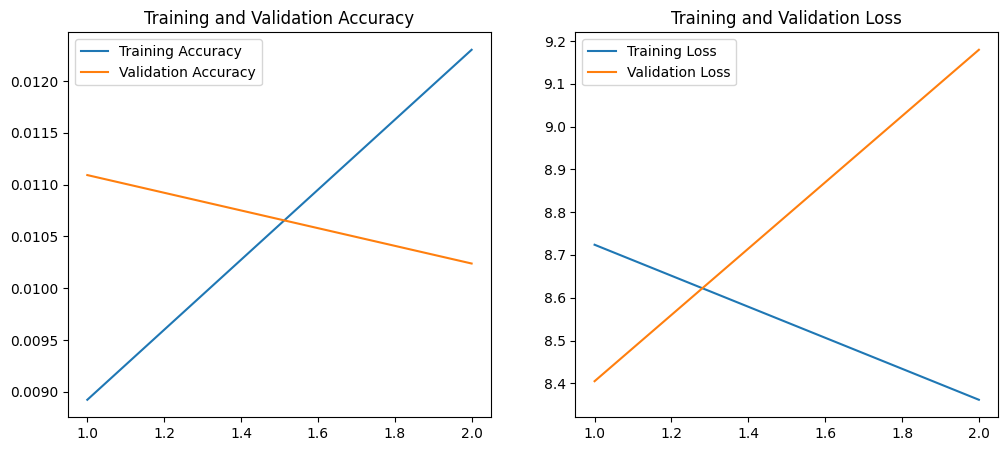

20/20 [==============================] - 6s 269ms/step
Classification Report:
                             precision    recall  f1-score   support

         Acadian_Flycatcher       0.00      0.00      0.00         7
              American_Crow       0.00      0.00      0.00         6
             American_Pipit       0.00      0.00      0.00         6
          American_Redstart       0.00      0.00      0.00         6
           Anna_Hummingbird       0.00      0.00      0.00         6
                 Artic_Tern       0.00      0.00      0.00         7
              Baird_Sparrow       0.00      0.00      0.00         5
           Baltimore_Oriole       0.00      0.00      0.00         6
               Bank_Swallow       0.00      0.00      0.00         7
               Barn_Swallow       0.00      0.00      0.00         6
       Bay_breasted_Warbler       0.00      0.00      0.00         6
          Belted_Kingfisher       0.00      0.00      0.00         6
                Bewick_W

C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(avera

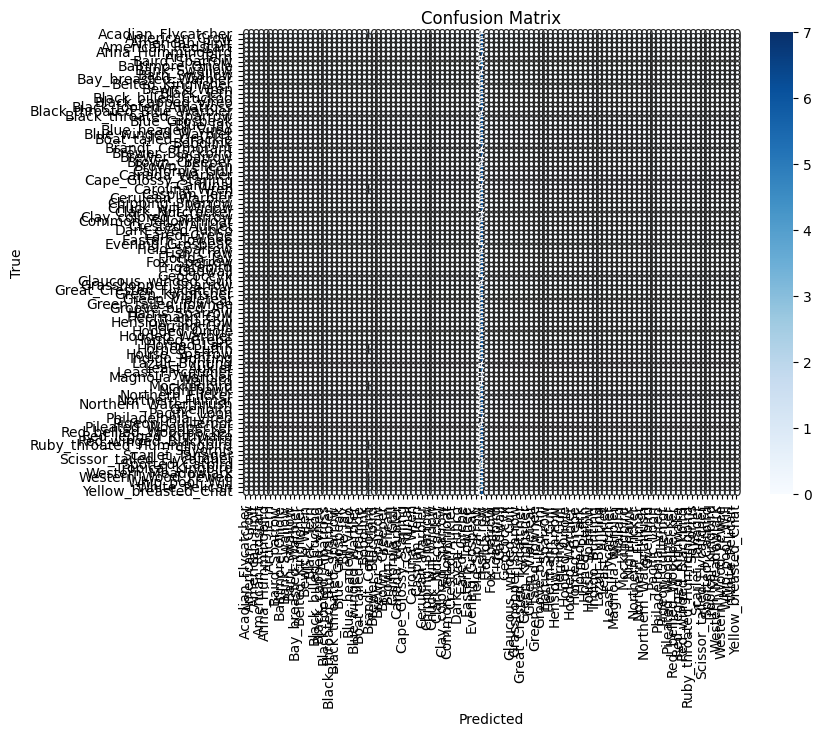

In [45]:
train_dir, val_dir, test_dir = os.path.join(destination_dataset_path, 'train'), os.path.join(destination_dataset_path, 'val'), os.path.join(destination_dataset_path, 'test')
train_generator, val_generator, test_generator = load_images_from_folder(train_dir, val_dir, test_dir)
class_names = list(train_generator.class_indices.keys())

model = train_vit_model(train_generator, val_generator, 
                        input_shape=input_shape, 
                        num_classes=len(class_names), 
                        transformer_layers=2, 
                        epochs=2 
                       )

evaluate_model(model, test_generator, class_names)

# 20250117 - Use ViT Pre-train model

[Using pre-trained Vision Transformer model and ResNet model as features extractors for image popularity prediction Link](https://medium.com/@james.sc.yan/using-pre-trained-vision-transformer-model-and-resnet-model-as-features-extractors-for-image-2292096e99a)

In [1]:
# !pip install keras_cv -q

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from keras_cv.models import ViTClassifier
import os
import matplotlib.pyplot as plt


Using TensorFlow backend


C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'ViTClassifier' from 'keras_cv.models' (C:\ProjectWork\Basic_Python\Zero_shot_Learning\venv_zsl\lib\site-packages\keras_cv\api\models\__init__.py)

In [ ]:
# Define dataset path and parameters
source_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'images')
destination_dataset_path = os.path.join('..', 'Dataset', 'CUB_KMean_Dataset', 'ViT_data')
model_dir = os.path.join('..', 'Models_ViT')
checkpoint_file_name = "checkpoint_ViT_epoch_{epoch:02d}_{accuracy:.4f}_{loss:.4f}_{val_accuracy:.4f}_{val_loss:.4f}_.h5"

dataset_dir = "path/to/dataset"
batch_size = 32
image_size = (224, 224)
num_classes = 101
learning_rate = 1e-4
epochs = 10